In [1]:
#loading packages
library(rvest)
library(tidyverse)
library(dplyr)
library(ggplot2)
library(magrittr) 
library(purrr) 
library(glue)
library(stringr) 
library(httr)
library(jsonlite)
library(gapminder)
library(readxl)
library(lubridate)
library(visdat)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.3     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter()         masks stats::filter()
✖ readr::guess_encoding() masks rvest::guess_encoding()
✖ dplyr::lag()            masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: 'magrittr'


The following object is masked from 'package:purrr':

    set_names


The following object is masked from 'package:tidyr':

    extract



Attaching package: 'jsonlite'


The following object is masked from 'package:purrr':

    flatten




In [2]:
df = read_excel('polrights_fh.xlsx') #new dataset
dfbmi = read_csv('bmi_data.csv') #original dataset

head(df, 3)

Rows: 24570 Columns: 34
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (18): IndicatorCode, Indicator, ValueType, ParentLocationCode, ParentLo...
dbl   (5): Period, FactValueNumeric, FactValueNumericLow, FactValueNumericHi...
lgl  (10): IsLatestYear, Dim3 type, Dim3, Dim3ValueCode, DataSourceDimValueC...
dttm  (1): DateModified

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


country,1972,1973,1974,1975,1976,1977,1978,1979,1980,⋯,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Afghanistan,4,7,7,7,7,6,7,7,7,⋯,6,6,6,6,5,5,5,5,7,7
Angola,NA,NA,NA,6,6,7,7,7,7,⋯,6,6,6,6,6,6,6,6,6,6
Albania,7,7,7,7,7,7,7,7,7,⋯,3,3,3,3,3,3,3,3,3,3


In [3]:
#pivoting and filtering the new dataset
pivot_df = df %>%
    pivot_longer(cols = -country, names_to='Year', values_to='Freedom_index')

pivot_df = pivot_df %>%
    filter(Year > 1974, Year < 2017) %>% #filtering to the same timespan
    drop_na() %>%
    mutate(year = as.factor(Year),
          Freedom_index = as.factor(Freedom_index))

In [4]:
bmi_sorted = dfbmi %>%
        arrange(Location, decreasing=TRUE)

pivot_sorted = pivot_df %>%
    arrange(country, decreasing=TRUE)

head(bmi_sorted)
head(pivot_sorted)

IndicatorCode,Indicator,ValueType,ParentLocationCode,ParentLocation,Location type,SpatialDimValueCode,Location,Period type,Period,⋯,FactValueUoM,FactValueNumericLowPrefix,FactValueNumericLow,FactValueNumericHighPrefix,FactValueNumericHigh,Value,FactValueTranslationID,FactComments,Language,DateModified
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,⋯,<lgl>,<lgl>,<dbl>,<lgl>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<dttm>
NCD_BMI_MEAN,Mean BMI (kg/m²) (age-standardized estimate),numeric,EMR,Eastern Mediterranean,Country,AFG,Afghanistan,Year,2016,⋯,NA,NA,20.1,NA,25.1,22.6 [20.1 – 25.1],NA,NA,EN,2017-09-26 11:00:00
NCD_BMI_MEAN,Mean BMI (kg/m²) (age-standardized estimate),numeric,EMR,Eastern Mediterranean,Country,AFG,Afghanistan,Year,2016,⋯,NA,NA,22.0,NA,24.8,23.4 [22 – 24.8],NA,NA,EN,2017-09-26 11:00:00
NCD_BMI_MEAN,Mean BMI (kg/m²) (age-standardized estimate),numeric,EMR,Eastern Mediterranean,Country,AFG,Afghanistan,Year,2016,⋯,NA,NA,23.0,NA,25.3,24.1 [23 – 25.3],NA,NA,EN,2017-09-26 11:00:00
NCD_BMI_MEAN,Mean BMI (kg/m²) (age-standardized estimate),numeric,EMR,Eastern Mediterranean,Country,AFG,Afghanistan,Year,2015,⋯,NA,NA,20.1,NA,25.0,22.5 [20.1 – 25],NA,NA,EN,2017-09-26 11:00:00
NCD_BMI_MEAN,Mean BMI (kg/m²) (age-standardized estimate),numeric,EMR,Eastern Mediterranean,Country,AFG,Afghanistan,Year,2015,⋯,NA,NA,21.9,NA,24.6,23.3 [21.9 – 24.6],NA,NA,EN,2017-09-26 11:00:00
NCD_BMI_MEAN,Mean BMI (kg/m²) (age-standardized estimate),numeric,EMR,Eastern Mediterranean,Country,AFG,Afghanistan,Year,2015,⋯,NA,NA,22.9,NA,25.1,24 [22.9 – 25.1],NA,NA,EN,2017-09-26 11:00:00


country,Year,Freedom_index,year
<chr>,<chr>,<fct>,<fct>
Afghanistan,1975,7,1975
Afghanistan,1976,7,1976
Afghanistan,1977,6,1977
Afghanistan,1978,7,1978
Afghanistan,1979,7,1979
Afghanistan,1980,7,1980


In [5]:
#a very ugly replacement process that I will turn into a function
#essentially matching all the names so the sets can be merged
bmi_sorted$Location[bmi_sorted$Location == 'Venezuela (Bolivarian Republic of)'] <- 'Venezuela'
bmi_sorted$Location[bmi_sorted$Location == 'Bolivia (Plurinational State of)'] <- 'Bolivia'
bmi_sorted$Location[bmi_sorted$Location == 'Brunei Darussalam'] <- 'Brunei'
bmi_sorted$Location[bmi_sorted$Location == 'Cabo Verde'] <- 'Cape Verde'
bmi_sorted$Location[bmi_sorted$Location == 'Congo'] <- 'Congo, Rep.'
bmi_sorted$Location[bmi_sorted$Location == 'Côte d’Ivoire'] <- 'Cote d\'Ivoire'
bmi_sorted$Location[bmi_sorted$Location == 'Czechia'] <- 'Czech Republic'
bmi_sorted$Location[bmi_sorted$Location == 'Democratic Republic of the Congo'] <- 'Congo, Dem. Rep.'
bmi_sorted$Location[bmi_sorted$Location == 'Iran (Islamic Republic of)'] <- 'Iran'
bmi_sorted$Location[bmi_sorted$Location == 'Lao People\'s Democratic Republic'] <- 'Lao'
bmi_sorted$Location[bmi_sorted$Location == 'United Kingdom of Great Britain and Northern Ireland'] <- 'UK'
bmi_sorted$Location[bmi_sorted$Location == 'United Arab Emirates'] <- 'UAE'
bmi_sorted$Location[bmi_sorted$Location == 'United States of America'] <- 'USA'
bmi_sorted$Location[bmi_sorted$Location == 'Viet Nam'] <- 'Vietnam'
bmi_sorted$Location[bmi_sorted$Location == 'United Republic of Tanzania'] <- 'Tanzania'
bmi_sorted$Location[bmi_sorted$Location == 'Türkiye'] <- 'Turkey'
bmi_sorted$Location[bmi_sorted$Location == 'Democratic People\'s Republic of Korea'] <- 'North Korea'
bmi_sorted$Location[bmi_sorted$Location == 'Republic of Korea'] <- 'South Korea'
bmi_sorted$Location[bmi_sorted$Location == 'Saint Kitts and Nevis'] <- 'St. Kitts and Nevis'
bmi_sorted$Location[bmi_sorted$Location == 'Syrian Arab Republic'] <- 'Syria'
bmi_sorted$Location[bmi_sorted$Location == 'Russian Federation'] <- 'Russia'
bmi_sorted$Location[bmi_sorted$Location == 'Republic of Moldova'] <- 'Moldova'
bmi_sorted$Location[bmi_sorted$Location == 'Saint Vincent and the Grenadines'] <- 'St. Vincent and the Grenadines'
bmi_sorted$Location[bmi_sorted$Location == 'Micronesia (Federated States of)'] <- 'Micronesia, Fed. Sts.'
bmi_sorted$Location[bmi_sorted$Location == 'Kyrgyz Republic'] <- 'Kyrgyzstan'
bmi_sorted$Location[bmi_sorted$Location == 'The former Yugoslav Republic of Macedonia'] <- 'North Macedonia'
bmi_sorted$Location[bmi_sorted$Location == 'Slovak Republic'] <- 'Slovakia'
bmi_sorted$Location[bmi_sorted$Location == 'Saint Lucia'] <- 'St. Lucia'
bmi_sorted$Location[bmi_sorted$Location == 'Kyrgyzstan'] <- 'Kyrgyz Republic'
bmi_sorted$Location[bmi_sorted$Location== 'Slovak Republic'] <- 'Slovakia'


pivot_sorted$country[pivot_sorted$country == 'Cote d\'Ivoire'] <- 'Côte d’Ivoire'

In [6]:
#going to merge on country and year. so need to rename cols
bmi_sorted = bmi_sorted %>%
    rename('country' = 'Location',
           'year' = 'Period') %>%
    mutate(year = as.factor(year))

In [7]:
#there are 3 measurements for each country.  Male, female and both.
#need to duplicate the obs in my new dataset

#number of times to duplicate each row
n_duplicates <- 3

#duplicate rows using rep()
duplicated_df <- pivot_sorted[rep(seq_len(nrow(pivot_sorted)), each = n_duplicates), ]

#reset row names
row.names(duplicated_df) <- NULL

#duplicated_df

In [8]:
#inner join
merged_df <- inner_join(duplicated_df, bmi_sorted, by = c("country", 'year'), relationship =
  "many-to-many")

#this creates 3 times the number of observations :(

In [9]:
#need to iterate over the dataframe to keep 3 rows and then skip the next 6

num_rows <- nrow(merged_df)
result <- data.frame()

rows_to_keep <- 3
rows_to_skip <- 6

for (i in seq(1, num_rows, by = rows_to_keep + rows_to_skip)) {
  #select the current subset of rows
  current_subset <- merged_df[i:(i + rows_to_keep - 1), ]
  
  #append the subset to the result dataframe
  result <- rbind(result, current_subset)
}

head(result)

country,Year,Freedom_index,year,IndicatorCode,Indicator,ValueType,ParentLocationCode,ParentLocation,Location type,⋯,FactValueUoM,FactValueNumericLowPrefix,FactValueNumericLow,FactValueNumericHighPrefix,FactValueNumericHigh,Value,FactValueTranslationID,FactComments,Language,DateModified
<chr>,<chr>,<fct>,<fct>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<lgl>,<lgl>,<dbl>,<lgl>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<dttm>
Afghanistan,1975,7,1975,NCD_BMI_MEAN,Mean BMI (kg/m²) (age-standardized estimate),numeric,EMR,Eastern Mediterranean,Country,⋯,NA,NA,15.8,NA,21.9,18.9 [15.8 – 21.9],NA,NA,EN,2017-09-26 11:00:00
Afghanistan,1975,7,1975,NCD_BMI_MEAN,Mean BMI (kg/m²) (age-standardized estimate),numeric,EMR,Eastern Mediterranean,Country,⋯,NA,NA,16.9,NA,21.0,18.9 [16.9 – 21],NA,NA,EN,2017-09-26 11:00:00
Afghanistan,1975,7,1975,NCD_BMI_MEAN,Mean BMI (kg/m²) (age-standardized estimate),numeric,EMR,Eastern Mediterranean,Country,⋯,NA,NA,16.3,NA,21.7,19 [16.3 – 21.7],NA,NA,EN,2017-09-26 11:00:00
Afghanistan,1976,7,1976,NCD_BMI_MEAN,Mean BMI (kg/m²) (age-standardized estimate),numeric,EMR,Eastern Mediterranean,Country,⋯,NA,NA,15.9,NA,22.0,19 [15.9 – 22],NA,NA,EN,2017-09-26 11:00:00
Afghanistan,1976,7,1976,NCD_BMI_MEAN,Mean BMI (kg/m²) (age-standardized estimate),numeric,EMR,Eastern Mediterranean,Country,⋯,NA,NA,17.0,NA,21.0,19 [17 – 21],NA,NA,EN,2017-09-26 11:00:00
Afghanistan,1976,7,1976,NCD_BMI_MEAN,Mean BMI (kg/m²) (age-standardized estimate),numeric,EMR,Eastern Mediterranean,Country,⋯,NA,NA,16.5,NA,21.7,19.1 [16.5 – 21.7],NA,NA,EN,2017-09-26 11:00:00


In [10]:
#want to rename the columns so will remove all spaces and replace them with '_'

for (col in colnames(result)) {
  new_col_name <- gsub(" ", "_", col)
  colnames(result)[colnames(result) == col] <- new_col_name
}

In [11]:
#renaming the columns and adjusting datatypes
result = result %>%
    mutate(year = Year, 
           region_code = as.factor(ParentLocationCode),
           country_code = as.factor(SpatialDimValueCode),
           region = as.factor(ParentLocation),
           gender = as.factor(Dim1),
           age = as.factor(Dim2),
           bmi_ave = FactValueNumeric,
           bmi_low = FactValueNumericLow,
            bmi_high = FactValueNumericHigh
           
           
    )

In [12]:
#keep the relevant rows
dff = result %>%
    select(year, country, Freedom_index, region, 
       region_code, country_code, gender, 
           bmi_ave, bmi_low, bmi_high,
       )
       
head(dff, 3)

year,country,Freedom_index,region,region_code,country_code,gender,bmi_ave,bmi_low,bmi_high
<chr>,<chr>,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>
1975,Afghanistan,7,Eastern Mediterranean,EMR,AFG,Female,18.9,15.8,21.9
1975,Afghanistan,7,Eastern Mediterranean,EMR,AFG,Both sexes,18.9,16.9,21.0
1975,Afghanistan,7,Eastern Mediterranean,EMR,AFG,Male,19.0,16.3,21.7


Rows: 21,576
Columns: 10
$ year          <chr> "1975", "1975", "1975", "1976", "1976", "1976", "1977", …
$ country       <chr> "Afghanistan", "Afghanistan", "Afghanistan", "Afghanista…
$ Freedom_index <fct> 7, 7, 7, 7, 7, 7, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,…
$ region        <fct> Eastern Mediterranean, Eastern Mediterranean, Eastern Me…
$ region_code   <fct> EMR, EMR, EMR, EMR, EMR, EMR, EMR, EMR, EMR, EMR, EMR, E…
$ country_code  <fct> AFG, AFG, AFG, AFG, AFG, AFG, AFG, AFG, AFG, AFG, AFG, A…
$ gender        <fct> Female, Both sexes, Male, Female, Both sexes, Male, Fema…
$ bmi_ave       <dbl> 18.9, 18.9, 19.0, 19.0, 19.0, 19.1, 19.1, 19.2, 19.2, 19…
$ bmi_low       <dbl> 15.8, 16.9, 16.3, 15.9, 17.0, 16.5, 16.2, 16.6, 17.2, 16…
$ bmi_high      <dbl> 21.9, 21.0, 21.7, 22.0, 21.0, 21.7, 22.0, 21.8, 21.1, 22…


     year             country          Freedom_index 
 Length:21576       Length:21576       1      :5568  
 Class :character   Class :character   6      :3621  
 Mode  :character   Mode  :character   2      :3183  
                                       7      :3006  
                                       5      :2184  
                                       3      :2070  
                                       (Other):1944  
                   region     region_code  country_code          gender    
 Africa               :5460   AFR :5460   AFG    :  123   Both sexes:7192  
 Americas             :4215   AMR :4215   AGO    :  123   Female    :7192  
 Eastern Mediterranean:2577   EMR :2577   ALB    :  123   Male      :7192  
 Europe               :5172   EUR :5172   ARE    :  123                    
 South-East Asia      :1284   SEAR:1284   ARG    :  123                    
 Western Pacific      :2868   WPR :2868   AUS    :  123                    
                                    

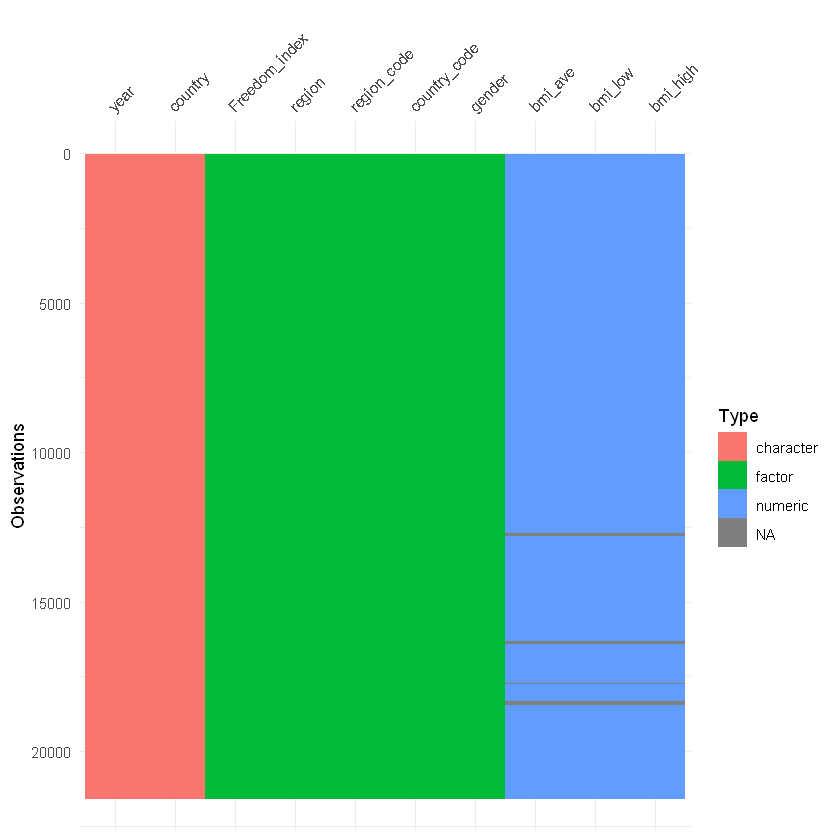

In [13]:
#check the results
dff %>%
    glimpse() %>%
    vis_dat() 
summary(dff)
